# Dual-Network Hydrogel Mastercurve

Auto TTS on dual-network hydrogels across temperature.

**Data:** examples/data/pyRheo/dual_network_hydrogel/*.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-07 17:31:43,551:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load multi-temperature sweeps (UTF-16)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'dual_network_hydrogel'
files = sorted(DATA_DIR.glob('*.csv'))

datasets = []
for fpath in files:
    stem = fpath.stem
    temp_token = stem.split('_')[-1]
    temp_c = float(temp_token.replace('c','').replace('h',''))
    df = pd.read_csv(fpath, encoding='utf-16', sep='	', skiprows=6, names=['omega', 'Gp', 'Gpp'], decimal=',')
    df = df.dropna()
    df['omega'] = pd.to_numeric(df['omega'], errors='coerce')
    df['Gp'] = pd.to_numeric(df['Gp'], errors='coerce')
    df['Gpp'] = pd.to_numeric(df['Gpp'], errors='coerce')
    df = df.dropna()
    if df.empty:
        continue
    omega = df['omega'].to_numpy()
    Gp = df['Gp'].to_numpy()
    Gpp = df['Gpp'].to_numpy()
    datasets.append(RheoData(x=omega, y=Gp + 1j*Gpp, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'temperature': temp_c + 273.15, 'test_mode': 'oscillation'}))

mc = Mastercurve(reference_temp=298.15, method='wlf', auto_shift=True)
try:
    master, shifts = mc.create_mastercurve(datasets, return_shifts=True)
except Exception as exc:
    print(f"Auto-shift failed: {exc}; falling back to manual identity shifts")
    manual_shifts = {d.metadata['temperature']: 1.0 for d in datasets}
    mc = Mastercurve(reference_temp=298.15, method='manual', auto_shift=False)
    mc.set_manual_shifts(manual_shifts)
    master, shifts = mc.create_mastercurve(datasets, return_shifts=True)

print(f"Temps (C): {[round(d.metadata['temperature']-273.15,1) for d in datasets]}")
print(shifts)


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 1.171806s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1.604529e-02 | time=1.172s | final_gradient_norm=0.0015533703418106014


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.196225s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=4.962596e-03 | time=0.196s | final_gradient_norm=0.0002285541641079793


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.202251s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.770224e-03 | time=0.202s | final_gradient_norm=0.018445553809993312


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.200442s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=9.730404e-04 | time=0.200s | final_gradient_norm=0.0037456368063177206


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.173750s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.008454e-03 | time=0.174s | final_gradient_norm=0.008862433175112216


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.180933s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=5.247366e-04 | time=0.181s | final_gradient_norm=0.0056939555408861975


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.180382s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=4.272324e-04 | time=0.180s | final_gradient_norm=2.5688033456501867e-05


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.180783s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=2.081711e-04 | time=0.181s | final_gradient_norm=0.0023675962427093804


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.179424s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1.005200e-03 | time=0.179s | final_gradient_norm=0.001098082935109922


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.190325s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=7.687195e-04 | time=0.190s | final_gradient_norm=0.012715143258230439


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.250172s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=1.264653e-02 | time=0.250s | final_gradient_norm=241837.47442982648


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-08, 'xtol': 1e-08, 'gtol': 1e-06}


Timer: optimization took 0.238235s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=33 | final_cost=8.801456e-03 | time=0.238s | final_gradient_norm=12757.225495054028


Temps (C): [10.0, 10.0, 20.0, 30.0, 40.0, 50.0]
{283.15: np.float64(1.114781348122104), 293.15: np.float64(1.0), 303.15: np.float64(2.0716235222245247), 313.15: np.float64(4013.5714885727525), 323.15: np.float64(5966.780997628978)}


## Plot raw vs shifted

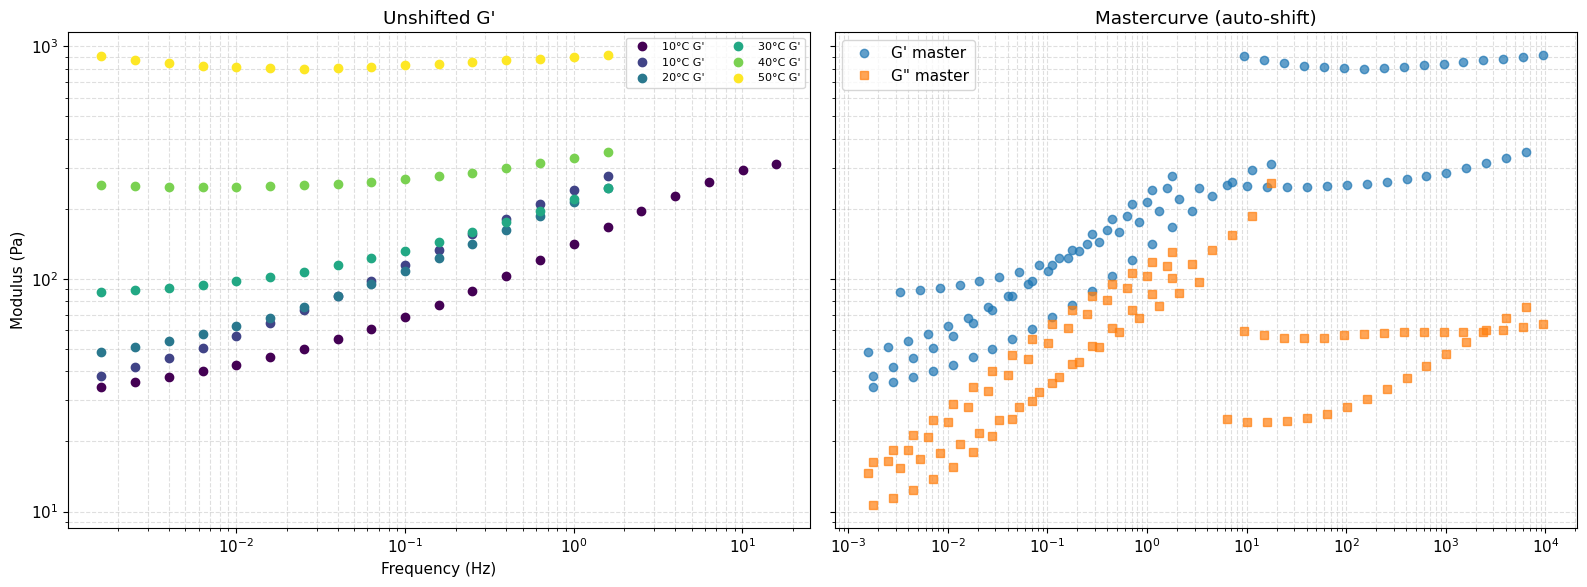

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))
for c, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x/(2*np.pi), np.real(data.y), 'o', color=c, label=f"{temp_c:.0f}°C G'")
axes[0].set_title("Unshifted G'")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (Pa)')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x/(2*np.pi), np.real(master.y), 'o', label="G' master", alpha=0.7)
axes[1].loglog(master.x/(2*np.pi), np.imag(master.y), 's', label='G" master', alpha=0.7)
axes[1].set_title('Mastercurve (auto-shift)')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.714603s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=1.406711e+06 | time=0.715s | final_gradient_norm=65.75140123766302


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.232510s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=1.406711e+06 | time=0.233s | final_gradient_norm=65.75140123766302


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.626740s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.408001e+06 | time=0.627s | final_gradient_norm=76989302634.50606


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.589374s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.415994e+06 | time=0.589s | final_gradient_norm=178282814726.3972


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.629526s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.504957e+06 | time=0.630s | final_gradient_norm=2460372131319.7905


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.188492s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.588234e+06 | time=0.188s | final_gradient_norm=9215369059.845541


Element minimization: reducing from 5 to 1 modes


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.959524s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=26 | final_cost=1.430002e+01 | time=0.960s | final_gradient_norm=0.031436418513683693


{'gm_r2': 0.5736802519113267, 'fm_r2': 0.339126689842953}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.236293s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=2.054597e+04 | time=0.236s | final_gradient_norm=25186166.43075365


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.412115s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=69 | final_cost=6.343465e-02 | time=0.412s | final_gradient_norm=0.00017071734462780166


Model ranking (R²): [('gm', -0.748), ('fm', -2.82)]


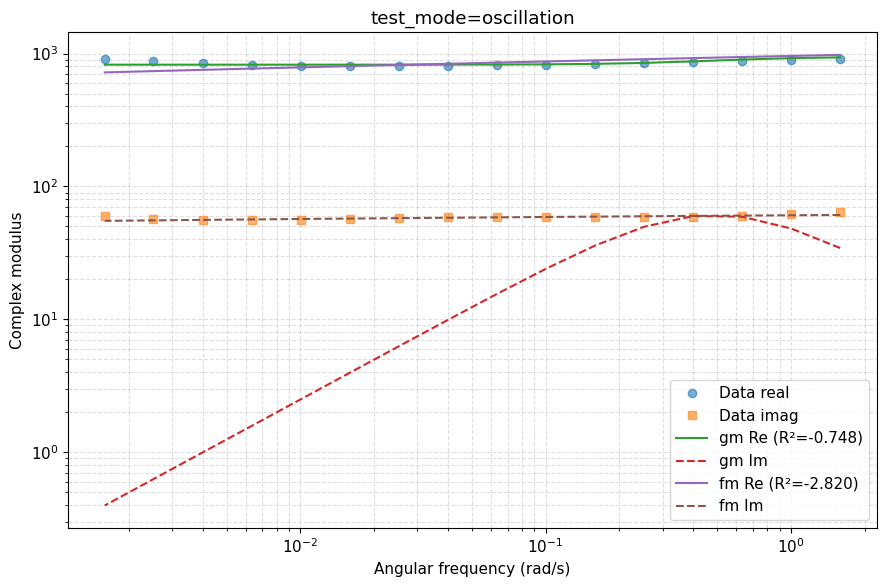

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<41:43,  1.60it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:  11%|█         | 436/4000 [00:00<00:04, 808.91it/s, 63 steps of size 1.04e-01. acc. prob=0.79]

warmup:  23%|██▎       | 906/4000 [00:00<00:01, 1624.34it/s, 15 steps of size 2.06e-01. acc. prob=0.79]

sample:  34%|███▍      | 1351/4000 [00:00<00:01, 2274.83it/s, 15 steps of size 1.71e-01. acc. prob=0.95]

sample:  46%|████▌     | 1823/4000 [00:01<00:00, 2879.47it/s, 15 steps of size 1.71e-01. acc. prob=0.95]

sample:  57%|█████▋    | 2295/4000 [00:01<00:00, 3358.93it/s, 31 steps of size 1.71e-01. acc. prob=0.94]

sample:  69%|██████▉   | 2762/4000 [00:01<00:00, 3713.30it/s, 31 steps of size 1.71e-01. acc. prob=0.94]

sample:  80%|████████  | 3211/4000 [00:01<00:00, 3929.93it/s, 15 steps of size 1.71e-01. acc. prob=0.94]

sample:  92%|█████████▏| 3665/4000 [00:01<00:00, 4103.37it/s, 15 steps of size 1.71e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2672.02it/s, 15 steps of size 1.71e-01. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:  12%|█▏        | 462/4000 [00:00<00:00, 4612.90it/s, 7 steps of size 2.47e-01. acc. prob=0.79]

warmup:  23%|██▎       | 933/4000 [00:00<00:00, 4668.00it/s, 7 steps of size 2.61e-01. acc. prob=0.79]

sample:  35%|███▌      | 1400/4000 [00:00<00:00, 4423.56it/s, 15 steps of size 1.72e-01. acc. prob=0.92]

sample:  46%|████▋     | 1857/4000 [00:00<00:00, 4476.66it/s, 31 steps of size 1.72e-01. acc. prob=0.92]

sample:  58%|█████▊    | 2318/4000 [00:00<00:00, 4523.17it/s, 15 steps of size 1.72e-01. acc. prob=0.92]

sample:  70%|██████▉   | 2789/4000 [00:00<00:00, 4582.09it/s, 31 steps of size 1.72e-01. acc. prob=0.93]

sample:  81%|████████▏ | 3255/4000 [00:00<00:00, 4606.81it/s, 15 steps of size 1.72e-01. acc. prob=0.92]

sample:  93%|█████████▎| 3730/4000 [00:00<00:00, 4651.86it/s, 7 steps of size 1.72e-01. acc. prob=0.93] 

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4592.64it/s, 31 steps of size 1.72e-01. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:  12%|█▏        | 461/4000 [00:00<00:00, 4605.95it/s, 31 steps of size 2.65e-01. acc. prob=0.79]

warmup:  24%|██▍       | 965/4000 [00:00<00:00, 4859.01it/s, 127 steps of size 7.08e-02. acc. prob=0.79]

sample:  36%|███▋      | 1451/4000 [00:00<00:00, 4682.05it/s, 15 steps of size 2.02e-01. acc. prob=0.92]

sample:  48%|████▊     | 1920/4000 [00:00<00:00, 4650.13it/s, 15 steps of size 2.02e-01. acc. prob=0.92]

sample:  60%|█████▉    | 2386/4000 [00:00<00:00, 4614.10it/s, 15 steps of size 2.02e-01. acc. prob=0.91]

sample:  71%|███████   | 2848/4000 [00:00<00:00, 4609.52it/s, 15 steps of size 2.02e-01. acc. prob=0.91]

sample:  83%|████████▎ | 3315/4000 [00:00<00:00, 4627.59it/s, 15 steps of size 2.02e-01. acc. prob=0.91]

sample:  94%|█████████▍| 3780/4000 [00:00<00:00, 4634.38it/s, 15 steps of size 2.02e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4552.04it/s, 15 steps of size 2.02e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:  12%|█▏        | 461/4000 [00:00<00:00, 4602.28it/s, 15 steps of size 2.24e-01. acc. prob=0.78]

warmup:  23%|██▎       | 926/4000 [00:00<00:00, 4630.09it/s, 7 steps of size 2.46e-01. acc. prob=0.79] 

sample:  35%|███▍      | 1392/4000 [00:00<00:00, 4640.42it/s, 15 steps of size 1.97e-01. acc. prob=0.93]

sample:  47%|████▋     | 1862/4000 [00:00<00:00, 4662.40it/s, 15 steps of size 1.97e-01. acc. prob=0.92]

sample:  58%|█████▊    | 2335/4000 [00:00<00:00, 4683.54it/s, 15 steps of size 1.97e-01. acc. prob=0.92]

sample:  70%|███████   | 2804/4000 [00:00<00:00, 4654.11it/s, 31 steps of size 1.97e-01. acc. prob=0.92]

sample:  82%|████████▏ | 3270/4000 [00:00<00:00, 4634.77it/s, 15 steps of size 1.97e-01. acc. prob=0.92]

sample:  94%|█████████▍| 3753/4000 [00:00<00:00, 4693.63it/s, 23 steps of size 1.97e-01. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4678.99it/s, 23 steps of size 1.97e-01. acc. prob=0.92]

array([[<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_1'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigma_imag'>, <Axes: xlabel='sigma_real'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
        <Axes: title={'center': 'tau_1\n1'}>,
        <Axes: title={'center': 'tau_1\n2'}>,
        <Axes: title={'center': 'tau_1\n3'}>]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >]], dtype=object)

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.186306s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=1.588234e+06 | time=0.186s | final_gradient_norm=9599707243.126137


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.318271s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=26 | final_cost=1.430002e+01 | time=0.318s | final_gradient_norm=0.031436418513683693


Model ranking (R²): [('gm', 0.574), ('fm', 0.339)]


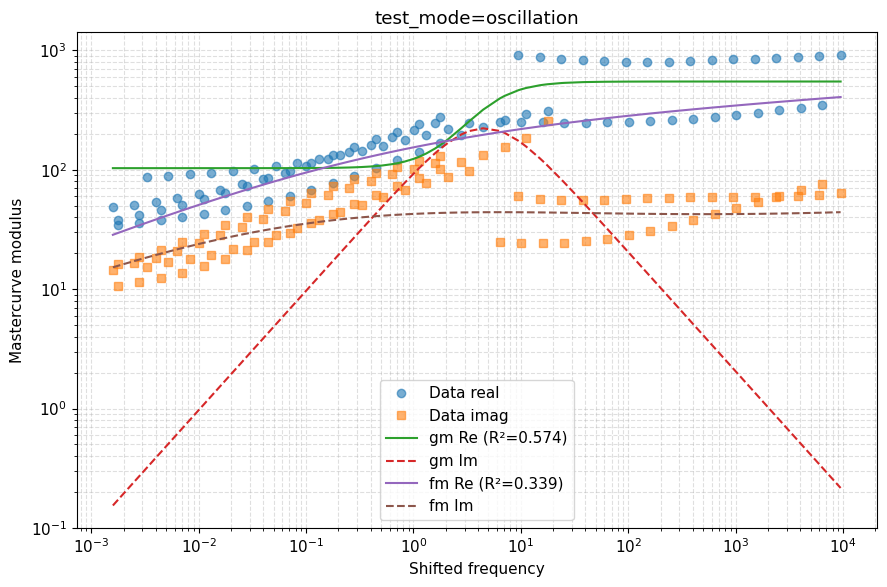

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<40:05,  1.66it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   6%|▌         | 248/4000 [00:00<00:07, 475.05it/s, 31 steps of size 2.99e-01. acc. prob=0.78]

warmup:  14%|█▍        | 579/4000 [00:00<00:03, 1084.68it/s, 15 steps of size 3.20e-01. acc. prob=0.79]

warmup:  21%|██▏       | 856/4000 [00:00<00:02, 1480.57it/s, 3 steps of size 8.10e-01. acc. prob=0.79] 

sample:  30%|███       | 1206/4000 [00:01<00:01, 1987.07it/s, 7 steps of size 5.43e-01. acc. prob=0.88]

sample:  39%|███▉      | 1562/4000 [00:01<00:01, 2401.71it/s, 3 steps of size 5.43e-01. acc. prob=0.87]

sample:  48%|████▊     | 1904/4000 [00:01<00:00, 2677.51it/s, 15 steps of size 5.43e-01. acc. prob=0.87]

sample:  56%|█████▋    | 2260/4000 [00:01<00:00, 2924.03it/s, 7 steps of size 5.43e-01. acc. prob=0.86] 

sample:  65%|██████▌   | 2604/4000 [00:01<00:00, 3070.92it/s, 7 steps of size 5.43e-01. acc. prob=0.86]

sample:  74%|███████▎  | 2945/4000 [00:01<00:00, 3168.37it/s, 3 steps of size 5.43e-01. acc. prob=0.86]

sample:  82%|████████▏ | 3290/4000 [00:01<00:00, 3249.34it/s, 7 steps of size 5.43e-01. acc. prob=0.86]

sample:  91%|█████████ | 3637/4000 [00:01<00:00, 3312.88it/s, 7 steps of size 5.43e-01. acc. prob=0.86]

sample: 100%|█████████▉| 3991/4000 [00:01<00:00, 3379.36it/s, 7 steps of size 5.43e-01. acc. prob=0.87]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2213.70it/s, 7 steps of size 5.43e-01. acc. prob=0.87]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   7%|▋         | 277/4000 [00:00<00:01, 2767.48it/s, 7 steps of size 1.01e+00. acc. prob=0.78]

warmup:  15%|█▍        | 592/4000 [00:00<00:01, 2990.06it/s, 7 steps of size 4.58e-01. acc. prob=0.79]

warmup:  24%|██▎       | 944/4000 [00:00<00:00, 3230.66it/s, 3 steps of size 4.78e-01. acc. prob=0.79]

sample:  32%|███▏      | 1275/4000 [00:00<00:00, 3261.59it/s, 7 steps of size 4.66e-01. acc. prob=0.90]

sample:  40%|████      | 1610/4000 [00:00<00:00, 3291.55it/s, 7 steps of size 4.66e-01. acc. prob=0.89]

sample:  49%|████▊     | 1946/4000 [00:00<00:00, 3311.80it/s, 7 steps of size 4.66e-01. acc. prob=0.90]

sample:  57%|█████▋    | 2278/4000 [00:00<00:00, 3304.72it/s, 3 steps of size 4.66e-01. acc. prob=0.90]

sample:  66%|██████▌   | 2624/4000 [00:00<00:00, 3351.12it/s, 7 steps of size 4.66e-01. acc. prob=0.90]

sample:  74%|███████▍  | 2960/4000 [00:00<00:00, 3347.59it/s, 7 steps of size 4.66e-01. acc. prob=0.90]

sample:  83%|████████▎ | 3307/4000 [00:01<00:00, 3383.03it/s, 7 steps of size 4.66e-01. acc. prob=0.90]

sample:  91%|█████████▏| 3652/4000 [00:01<00:00, 3402.71it/s, 7 steps of size 4.66e-01. acc. prob=0.90]

sample: 100%|█████████▉| 3993/4000 [00:01<00:00, 3382.67it/s, 7 steps of size 4.66e-01. acc. prob=0.90]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3312.33it/s, 7 steps of size 4.66e-01. acc. prob=0.90]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   7%|▋         | 296/4000 [00:00<00:01, 2953.00it/s, 7 steps of size 5.53e-01. acc. prob=0.78]

warmup:  16%|█▌        | 630/4000 [00:00<00:01, 3175.44it/s, 7 steps of size 7.96e-01. acc. prob=0.79]

warmup:  24%|██▍       | 977/4000 [00:00<00:00, 3307.90it/s, 7 steps of size 4.53e-01. acc. prob=0.79]

sample:  33%|███▎      | 1319/4000 [00:00<00:00, 3348.32it/s, 7 steps of size 4.92e-01. acc. prob=0.91]

sample:  41%|████▏     | 1654/4000 [00:00<00:00, 3338.95it/s, 7 steps of size 4.92e-01. acc. prob=0.91]

sample:  50%|████▉     | 1988/4000 [00:00<00:00, 3327.52it/s, 7 steps of size 4.92e-01. acc. prob=0.91]

sample:  58%|█████▊    | 2337/4000 [00:00<00:00, 3376.71it/s, 7 steps of size 4.92e-01. acc. prob=0.90]

sample:  67%|██████▋   | 2682/4000 [00:00<00:00, 3398.45it/s, 7 steps of size 4.92e-01. acc. prob=0.91]

sample:  76%|███████▌  | 3025/4000 [00:00<00:00, 3405.31it/s, 7 steps of size 4.92e-01. acc. prob=0.91]

sample:  84%|████████▍ | 3366/4000 [00:01<00:00, 3403.95it/s, 7 steps of size 4.92e-01. acc. prob=0.91]

sample:  93%|█████████▎| 3711/4000 [00:01<00:00, 3414.57it/s, 7 steps of size 4.92e-01. acc. prob=0.90]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3365.35it/s, 7 steps of size 4.92e-01. acc. prob=0.90]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   7%|▋         | 278/4000 [00:00<00:01, 2779.05it/s, 31 steps of size 1.68e-01. acc. prob=0.78]

warmup:  14%|█▍        | 556/4000 [00:00<00:01, 2768.13it/s, 7 steps of size 6.14e-01. acc. prob=0.79] 

warmup:  23%|██▎       | 920/4000 [00:00<00:00, 3161.16it/s, 7 steps of size 5.59e-01. acc. prob=0.79]

sample:  32%|███▏      | 1262/4000 [00:00<00:00, 3259.07it/s, 31 steps of size 4.32e-01. acc. prob=0.92]

sample:  40%|███▉      | 1596/4000 [00:00<00:00, 3287.55it/s, 3 steps of size 4.32e-01. acc. prob=0.92] 

sample:  48%|████▊     | 1925/4000 [00:00<00:00, 3270.57it/s, 7 steps of size 4.32e-01. acc. prob=0.92]

sample:  57%|█████▋    | 2274/4000 [00:00<00:00, 3340.61it/s, 7 steps of size 4.32e-01. acc. prob=0.92]

sample:  65%|██████▌   | 2619/4000 [00:00<00:00, 3374.41it/s, 23 steps of size 4.32e-01. acc. prob=0.92]

sample:  74%|███████▍  | 2958/4000 [00:00<00:00, 3379.13it/s, 15 steps of size 4.32e-01. acc. prob=0.92]

sample:  82%|████████▏ | 3296/4000 [00:01<00:00, 3376.42it/s, 7 steps of size 4.32e-01. acc. prob=0.92] 

sample:  91%|█████████ | 3638/4000 [00:01<00:00, 3387.81it/s, 7 steps of size 4.32e-01. acc. prob=0.92]

sample:  99%|█████████▉| 3979/4000 [00:01<00:00, 3393.35it/s, 7 steps of size 4.32e-01. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3304.08it/s, 7 steps of size 4.32e-01. acc. prob=0.92]

array([[<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_1'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigma_imag'>, <Axes: xlabel='sigma_real'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
        <Axes: title={'center': 'tau_1\n1'}>,
        <Axes: title={'center': 'tau_1\n2'}>,
        <Axes: title={'center': 'tau_1\n3'}>]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >]], dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
